# Parameter optimization and model simulation for MIMICSb

Three Steps
1. Load data lists of observation, model, and parameter ranges
2. Conduct optimization
3. Conduct simulation with the optimized parameters

Both the long-term field data and laboratory incubations data for the soils from the same site were used for parameter optimization because the soils used for field and laboratory experiments should have the same initial C pool fractions at the specific site in theory.
In this study, we only optimized beta that controls the microbial turnover rate and the initial pool sizes in order to minimize the issue of overfitting. All model parameters except for β were kept at their original values (Wieder et al., 2015) in the global simulations. 

In [1]:
# load library
library(SoilR) # Load the  SoilR  exp version
library(FME)
library(MASS)
library(lattice)
# library(rtop)
library(hydromad)
library(DEoptim)

Loading required package: deSolve

Warning message:
"package 'deSolve' was built under R version 4.0.4"
Loading required package: parallel

Loading required package: expm

Warning message:
"package 'expm' was built under R version 4.0.4"
Loading required package: Matrix


Attaching package: 'expm'


The following object is masked from 'package:Matrix':

    expm


Loading required package: RUnit

Warning message:
"package 'RUnit' was built under R version 4.0.4"
Loading required package: sets

Warning message:
"package 'sets' was built under R version 4.0.4"

Attaching package: 'SoilR'


The following object is masked from 'package:deSolve':

    euler


Warning message:
"package 'FME' was built under R version 4.0.4"
Loading required package: rootSolve

Warning message:
"package 'rootSolve' was built under R version 4.0.5"
Loading required package: coda

Warning message:
"package 'coda' was built under R version 4.0.4"
Loading required package: zoo

Warning message:
"package 'zoo' was

# 1. Load data lists of observation, model, and parameter ranges

## 1.1 Load data lists of observation

In [2]:
### 1. laod data that combine both field bare fallow 
### and laboratory incubation dataset
bfinc = read.csv(file = 'dinput/bf_inc_initial_final.csv')
# note: for long-term bare fallow (LTBF), date_sin is yearly step。
# for initial and final incubation (inital.inc and final.inc), date_sin is daily step.
# The unit of total SOC is mgC per cm3

In [3]:
unique(bfinc$site)

[1] "Askov"      "Grignon"    "Rothamsted" "Ultuna"     "Versailles"

In [4]:
head(bfinc) 

,site,temp,date_sin,SOC_mgC_per_cm3,bulkD,SOC_gC_per_kgSoil,exp_type
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,Askov,7.8,0,26.0250,1.5,17.35,LTBF
2,Askov,7.8,1,25.1625,1.5,16.78,LTBF
3,Askov,7.8,2,25.6500,1.5,17.10,LTBF
4,Askov,7.8,3,24.8250,1.5,16.55,LTBF
5,Askov,7.8,4,24.7500,1.5,16.50,LTBF
6,Askov,7.8,5,24.8250,1.5,16.55,LTBF


In [5]:
tail(na.omit(bfinc))

,site,temp,date_sin,SOC_mgC_per_cm3,bulkD,SOC_gC_per_kgSoil,exp_type
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
13586,Versailles,35,42,9.193113,1.44,6.384106,final.inc
13614,Versailles,35,70,9.144711,1.44,6.350494,final.inc
13649,Versailles,35,105,9.095017,1.44,6.315984,final.inc
13726,Versailles,35,182,8.997480,1.44,6.248250,final.inc
13840,Versailles,35,296,8.869601,1.44,6.159445,final.inc
13971,Versailles,35,427,8.798917,1.44,6.110359,final.inc


In [6]:
# load site-info containing clay content, initial TSOC, temperature, etc
siteinfo <- read.csv(file = 'dinput/site5info.csv')

## 1.2 Load model

In [7]:
# Consturct total SOC calculation function
model_name = 'MIMICSb'
# load model
source(paste0('code.proc/',model_name,'.R'))

# model to get total carbon
source('code.proc/TSOC_4temp_bf_MIMICSb.R')

## 1.3 Load parameter ranges

In [8]:
# load parameter range for parameter needing optimization
nopt = c('fMIC_1', 'fMIC_2', 'fSOM_1', 'fSOM_3', 'beta')
parm_range = data.frame(parname = nopt,
                        lower   = c(0.001, 0.001, 0.1, 0.001, 1.0001), 
                        best    = c(0.012, 0.012, 0.50, 0.15, 1.5), 
                        upper   = c(0.025, 0.025, 0.75, 0.2,  2))
# load reference parameter definition (best, upper, lower)
refPars <- parm_range[, 2:4]
rownames(refPars) = nopt
refPars

,lower,best,upper
,<dbl>,<dbl>,<dbl>
fMIC_1,0.0010,0.012,0.025
fMIC_2,0.0010,0.012,0.025
fSOM_1,0.1000,0.500,0.750
fSOM_3,0.0010,0.150,0.200
beta,1.0001,1.500,2.000


# 2. Conduct optimization

## 2.1 Conduct optimization for 4 sites

In [9]:
# Objective function, summing up squared differences
OFUN = function(pars, x,  yobs) {
  yvals = TSOC_4temp_bf_MIMICS(x, pars)
  sum((yvals-yobs)^2)
}

In [10]:
# conduct SCE opitimization
nsite = c('Askov', 'Grignon', 'Ultuna','Versailles')
MATS = c(7.8, 10.7, 5.5, 10.7) # site temperature
# data.frame storing the optimized parameter results
parm_opt <- data.frame(matrix(NA, ncol = length(nopt), nrow = length(nsite)))
colnames(parm_opt) <- nopt
rownames(parm_opt) <- nsite

In [11]:
obs_data = na.omit(bfinc)
# the final incubation is sampled at  
# last = c(1982, 2007, 2009, 2008) # four the four sites
lasts = c(26, 48, 53, 79)         # date_sin

In [12]:
 for (i in seq(1,4) ){
    isite = nsite[i]
    last  = lasts[i]
    driver = obs_data[obs_data$site == isite, ]
    CLAY = siteinfo[siteinfo$site==isite, ]$CLAY
    MAT = siteinfo[siteinfo$site==isite, ]$mat
    
    ibulkD = max(siteinfo[siteinfo$site==isite, 'bulkden_ini'],
                  siteinfo[siteinfo$site==isite, 'bulkden_fin'] )
    print(paste0(isite, ' bulkD ', ibulkD))
     
    # get site-specific parameter ranges for fQmax
    Fphs_max = siteinfo[siteinfo$site == isite, ]$Fphs_max
    refPars[3,3] = Fphs_max
    refPars[3,2] = max(Fphs_max/2, 0.11)
    refPars[3,1] = 0.1
     
    sceuares = SCEoptim(OFUN, par = refPars$best, lower = refPars$lower,
                    upper = refPars$upper, x = driver, yobs = driver$SOC_mgC_per_cm3)
    parm_opt[isite,] = sceuares$par
 }

[1] "Askov bulkD 1.5"
[1] "Grignon bulkD 1.21"
[1] "Ultuna bulkD 1.44"
[1] "Versailles bulkD 1.44"


In [13]:
parm_opt

,fMIC_1,fMIC_2,fSOM_1,fSOM_3,beta
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Askov,0.01730376,0.001000000,0.1689912,0.01031547,1.122187
Grignon,0.02499683,0.001000000,0.3365588,0.07907446,1.197534
Ultuna,0.02500000,0.001367913,0.3801833,0.08744170,1.151023
Versailles,0.02499989,0.001000000,0.1960947,0.04480430,1.166910


## 2.2 Conduct optimization for Rothamsted

For the site Rothamsted where no incubation experiments were conducted, the observed vs. predicted data lists of TSOC only include the field bare fallow dataset. 

In [14]:
# Consturct total SOC calculation function
# model to get total carbon
TSOC_Model_bf = function(driver, pars){
        fMIC_1 = pars[1]; fMIC_2 = pars[2]
        fSOM_1 = pars[3]; fSOM_3 = pars[4]
        fSOM_2 = 1- fMIC_1 - fMIC_2 - fSOM_1 - fSOM_3
        beta   = pars[5]
        Ex= MIMICS_BF(t = driver$date_sin, 
                      timestep = 24*365, # yearly
                      bulkD = ibulkD,
                      TSOI = TSOI,
                      CLAY = CLAY,
                      beta = beta,
                      ival = c(MIC_1= fMIC_1 * cint, MIC_2=fMIC_2*cint, 
                               SOM_1= fSOM_1 * cint, SOM_2=fSOM_2*cint, 
                               SOM_3= fSOM_3*cint))
        Ct=getC(Ex)
        return(TSOC_pre =rowSums(Ct)) # total carbon storage
        }

In [15]:
# Objective function, summing up squared differences
OFUN_bf = function(pars, x,  yobs) {
  yvals = TSOC_Model_bf(x, pars)
  sum((yvals-yobs)^2)
}

In [16]:
i = 'Rothamsted'
bf_roth = na.omit(bfinc[bfinc$site == i,])

TSOI = siteinfo[siteinfo$site==i, 'mat']
CLAY = siteinfo[siteinfo$site==i, ]$CLAY
ibulkD = max(siteinfo[siteinfo$site==isite, 'bulkden_ini'],
              siteinfo[siteinfo$site==isite, 'bulkden_fin'] )
cint = bf_roth[1, 'SOC_mgC_per_cm3']  # the initial total carbon pools

# get site-specific parameter ranges for fQmax
Fphs_max = siteinfo[siteinfo$site == i, ]$Fphs_max
refPars[3,3] = Fphs_max
refPars[3,2] = max(Fphs_max/2, 0.1001)
refPars[3,1] = 0.1

sceuares_roth = SCEoptim(OFUN_bf, par = refPars$best, lower = refPars$lower,
                    upper = refPars$upper, x = bf_roth, yobs = bf_roth$SOC_mgC_per_cm3) 

In [17]:
par_roth = sceuares_roth$par
parm_opt = rbind(parm_opt, par_roth)
parm_opt$site = c('Askov', 'Grignon', 'Ultuna','Versailles', 'Rothamsted')
parm_opt # from rtop

,fMIC_1,fMIC_2,fSOM_1,fSOM_3,beta,site
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Askov,0.01730376,0.001000000,0.1689912,0.01031547,1.122187,Askov
Grignon,0.02499683,0.001000000,0.3365588,0.07907446,1.197534,Grignon
Ultuna,0.02500000,0.001367913,0.3801833,0.08744170,1.151023,Ultuna
Versailles,0.02499989,0.001000000,0.1960947,0.04480430,1.166910,Versailles
5,0.02499825,0.017434764,0.1000002,0.05382432,1.082135,Rothamsted


In [18]:
model_name = 'MIMICSb'
write.csv(parm_opt, file = paste0('output/parameter_opt_', model_name,'.csv'), row.names = F)
# parameter optimization END!

# 3 Conduct simulation with the optimized parameters

## 3.1 Conduct simulation for field bare fallow

In [19]:
# load bare fallow data
bfdata = read.csv(file = 'dinput/bf.fill.150y.csv')
unique(bfdata$site)

[1] "Askov"      "Grignon"    "Rothamsted" "Ultuna"     "Versailles"

In [20]:
##conduct yearly-step simulation with optimized parameters
bfdata$MIC_1 = NA
bfdata$MIC_2 = NA
bfdata$SOM_1 = NA
bfdata$SOM_2 = NA
bfdata$SOM_3 = NA
bfdata$TSOC_pre = NA

nsite = c('Askov', 'Grignon', 'Rothamsted', 'Ultuna', 'Versailles')

for (i in unique(nsite))
{ tmp = bfdata[bfdata$site == i, ]
  # assign site-specific soil temperature and clay fraction 
  TSOI = siteinfo[siteinfo$site==i, 'mat']
  CLAY = siteinfo[siteinfo$site==i, ]$CLAY   
  cint   <- tmp[1, 'SOC_mgC_per_cm3']  # the initial total carbon pools 
  ibulkD = max(siteinfo[siteinfo$site==isite, 'bulkden_ini'],
                siteinfo[siteinfo$site==isite, 'bulkden_fin'] )
  # Assign the optimized parameter values
  fMIC_1 = parm_opt[parm_opt$site==i, 'fMIC_1']; fMIC_2 = parm_opt[parm_opt$site==i, 'fMIC_2']
  fSOM_1 = parm_opt[parm_opt$site==i, 'fSOM_1']; fSOM_3 = parm_opt[parm_opt$site==i, 'fSOM_3']
  fSOM_2 =  1- fMIC_1 - fMIC_2 - fSOM_1 - fSOM_3
  beta   = parm_opt[parm_opt$site==i, 'beta']
  Ex = MIMICS_BF(t =  tmp$years, 
                 timestep  = 24*365, # yearly step
                 bulkD = ibulkD,
                 TSOI = TSOI,
                 CLAY = CLAY,
                 beta = beta,
                 ival = c(MIC_1 = fMIC_1 * cint, 
                          MIC_2 = fMIC_2 * cint, 
                          SOM_1 = fSOM_1 * cint, 
                          SOM_2 = fSOM_2 * cint, 
                          SOM_3 = fSOM_3 * cint
                          ))
  Ct=getC(Ex)
  bfdata[bfdata$site == i, ]$MIC_1 = Ct[,1]
  bfdata[bfdata$site == i, ]$MIC_2 = Ct[,2]
  bfdata[bfdata$site == i, ]$SOM_1 = Ct[,3]
  bfdata[bfdata$site == i, ]$SOM_2 = Ct[,4]
  bfdata[bfdata$site == i, ]$SOM_3 = Ct[,5]
  bfdata[bfdata$site == i, ]$TSOC_pre  = rowSums(Ct)
 }

In [21]:
bfdata$TSOC_pre_kg = bfdata$TSOC_pre / bfdata$bulkD
write.csv(bfdata, file = paste0('output/prediction_BF_',model_name,'.csv'), row.names=F)

Warning message:
"package 'ggplot2' was built under R version 4.0.5"

Attaching package: 'ggplot2'


The following object is masked from 'package:latticeExtra':

    layer


Warning message:
"Removed 674 rows containing missing values (geom_point)."


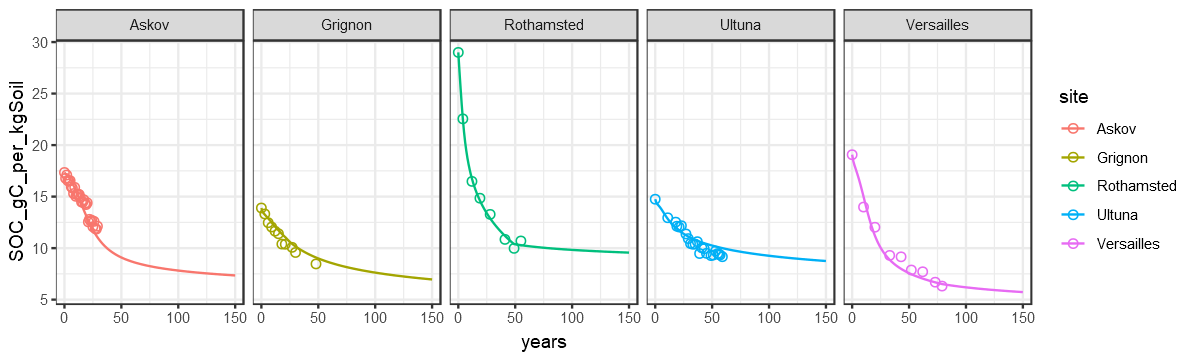

In [22]:
# predicted vs observed time-series plot
library(ggplot2)
tmp = bfdata
bf_scatter <- ggplot(aes(x = years , y = SOC_gC_per_kgSoil), data = tmp)+ 
  facet_grid(~ site) +
  geom_point(size=2,shape=1,aes(col=site)) +
  geom_line(aes(x = years, y = TSOC_pre_kg, col=site)) + 
  theme_bw() 
options(repr.plot.width = 10, repr.plot.height = 3)
bf_scatter

## 3.2 Conduct simulation for incubation at the initial stage

In [23]:
# load  obsersed incubation data
indata <- read.csv( 'dinput/bf_inc_initial_final.csv')
indata = indata[indata$exp_type == 'initial.inc', ]
nsite = unique(indata$site)
nsite

[1] "Askov"      "Grignon"    "Ultuna"     "Versailles"

In [24]:
# model to get total carbon for incubation experiments
source('code.proc/TSOC_4temp_MIMICSb.R')

In [25]:
# simulation with MIMICS0
indata$daysin = indata$date_sin
indata$TSOC_pre = NA
for (i in unique(indata$site)){
   driver = indata[indata$site == i, ]
   CLAY = siteinfo[siteinfo$site==i, ]$CLAY
   cint = driver[1, 'SOC_mgC_per_cm3']   # the initial total carbon
   ibulkD = max(siteinfo[siteinfo$site==i, 'bulkden_ini'],
                 siteinfo[siteinfo$site==i, 'bulkden_fin'] )    
   pars = as.matrix(parm_opt[parm_opt$site == i, 1:5])
   indata[indata$site == i, ]$TSOC_pre = TSOC_4temp_MIMICS(driver, pars)
    }

In [26]:
indata$TSOC_pre_kg = indata$TSOC_pre / indata$bulkD
write.csv(indata, file = paste0('output/prediction_incub_ini_',model_name,'.csv'), row.names=F)

### Predict individue pools for incubation at the final stage

In [27]:
indata$MIC_1 = NA
indata$MIC_2 = NA
indata$SOM_1 = NA
indata$SOM_2 = NA
indata$SOM_3 = NA
indata$TSOC_pre = NA

nsite = c('Askov', 'Grignon', 'Ultuna', 'Versailles')
temps = c(4, 12, 20, 35)
parm_opt = read.csv(file = 'doutput/parameter_opt_MIMICS0.csv')
for (i in unique(nsite))
   {
    # the initial total carbon  mgC per cm3 
    adata = indata[indata$site == i, ]
    cint = adata[1, 'SOC_mgC_per_cm3']   # the initial total carbon    
    
    CLAY = siteinfo[siteinfo$site==i, ]$CLAY 
    ibulkD = max(siteinfo[siteinfo$site==i, 'bulkden_ini'],
                  siteinfo[siteinfo$site==i, 'bulkden_fin'] )
    
    for (j in unique(temps))
        { tmp = adata[adata$temp == j, ]
          # assign site-specific soil temperature and clay fraction 
          TSOI = tmp[1, 'temp']
          timestep = 24 # daily step
          CLAY = siteinfo[siteinfo$site==i, ]$CLAY   

          # Assign the optimized parameter values
          fMIC_1 = parm_opt[parm_opt$site==i, 'fMIC_1']; fMIC_2 = parm_opt[parm_opt$site==i, 'fMIC_2']
          fSOM_1 = parm_opt[parm_opt$site==i, 'fSOM_1']; fSOM_3 = parm_opt[parm_opt$site==i, 'fSOM_3']
          beta   = parm_opt[parm_opt$site==i, 'beta']
          fSOM_2 = 1- fMIC_1 - fMIC_2 - fSOM_1 - fSOM_3
          Ex = MIMICS_BF(t =  tmp$daysin, 
                         timestep = timestep,
                         bulkD = ibulkD,
                              TSOI = TSOI,
                              CLAY = CLAY,
                              beta = beta,
                              ival = c(MIC_1= fMIC_1 * cint, MIC_2=fMIC_2*cint, 
                                       SOM_1= fSOM_1 * cint, SOM_2=fSOM_2*cint, SOM_3= fSOM_3*cint))
          Ct=getC(Ex)
          indata[indata$site ==i & indata$temp == j, ]$MIC_1 = Ct[,1]
          indata[indata$site ==i & indata$temp == j, ]$MIC_2 = Ct[,2]
          indata[indata$site ==i & indata$temp == j, ]$SOM_1 = Ct[,3]
          indata[indata$site ==i & indata$temp == j, ]$SOM_2 = Ct[,4]
          indata[indata$site ==i & indata$temp == j, ]$SOM_3 = Ct[,5]
          indata[indata$site ==i & indata$temp == j, ]$TSOC_pre  = rowSums(Ct)
         }
    }

In [28]:
indata$TSOC_pre_kg = indata$TSOC_pre / indata$bulkD
indata[,11:15] = indata[,11:15]/indata$bulkD
write.csv(indata, file = paste0('output/prediction_incub_initial_',model_name,'.csv'), row.names=F)

## 3.3 Conduct simulation for incubation at the final stage

In [29]:
# load  obsersed incubation data
findata <- read.csv( 'dinput/bf_inc_initial_final.csv')
findata = findata[findata$exp_type == 'final.inc', ]
nsite = unique(findata$site)
nsite

[1] "Askov"      "Grignon"    "Ultuna"     "Versailles"

In [30]:
# Get initial fractions of carbon pools for the incubation 
# with final samples
parm_opt_fin = parm_opt[,1:6]
parm_opt_fin[,1:4]  = NA

lasts = data.frame(site = unique(indata$site), 
                   years = c(26, 48, 53, 79)) 

for (i in unique(indata$site)){
   # calculate 
   last = lasts[lasts$site == i,]$years
        TSOC_fin = bfdata[bfdata$site ==i & bfdata$years == last,]
        fMIC_1 = TSOC_fin$MIC_1/TSOC_fin$TSOC_pre
        fMIC_2 = TSOC_fin$MIC_2/TSOC_fin$TSOC_pre
        fSOM_1 = TSOC_fin$SOM_1/TSOC_fin$TSOC_pre
        # fSOM_2 = TSOC_fin$SOM_2/TSOC_fin$TSOC_pre
        fSOM_3 = TSOC_fin$SOM_3/TSOC_fin$TSOC_pre
    
   # deliver pars values
   parm_opt_fin[parm_opt_fin$site ==i,1:4] = c(fMIC_1, fMIC_2, fSOM_1,  fSOM_3)
    }
parm_opt_fin

fMIC_1,fMIC_2,fSOM_1,fSOM_3,beta,site
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.004811676,0.0033750527,0.1994625,0.0868416,1.0907,Askov
0.002230793,0.0018690261,0.4041433,0.1367114,1.0776,Grignon
NA,NA,NA,NA,1.0000,Rothamsted
0.001132295,0.0008706271,0.3838761,0.1646834,1.0000,Ultuna
0.001252903,0.0010085045,0.3775681,0.1213772,1.0721,Versailles
NA,NA,NA,NA,1.0481,Average


In [31]:
# simulation with MIMICS0
findata$daysin = findata$date_sin
findata$TSOC_pre = NA
      
for (i in unique(indata$site)){
  
   driver = findata[findata$site == i, ]
   CLAY = siteinfo[siteinfo$site==i, ]$CLAY
   cint = driver[1, 'SOC_mgC_per_cm3']   # the initial total carbon
   ibulkD =max(siteinfo[siteinfo$site==i, 'bulkden_ini'],
                siteinfo[siteinfo$site==i, 'bulkden_fin'] )
   pars = as.matrix(parm_opt_fin[parm_opt_fin$site ==i, 1:5]) 
   
   findata[findata$site == i, ]$TSOC_pre = TSOC_4temp_MIMICS(driver, pars)
    }  

In [32]:
findata$TSOC_pre_kg = findata$TSOC_pre / findata$bulkD
write.csv(findata, file = paste0('output/prediction_incub_fin_',model_name,'.csv'), row.names=F)

The result above contain only total SOC, lacking individual pool sizes

### Predict individue pools for incubation at the final stage

In [33]:
findata$MIC_1 = NA
findata$MIC_2 = NA
findata$SOM_1 = NA
findata$SOM_2 = NA
findata$SOM_3 = NA
findata$TSOC_pre = NA

nsite = c('Askov', 'Grignon', 'Ultuna', 'Versailles')
temps = c(4, 12, 20, 35)

for (i in unique(nsite))
   {
    # the initial total carbon  mgC per cm3 
    adata = findata[findata$site == i, ]
    cint = adata[1, 'SOC_mgC_per_cm3']   # the initial total carbon    
    
    CLAY = siteinfo[siteinfo$site==i, ]$CLAY 
    ibulkD =max(siteinfo[siteinfo$site==i, 'bulkden_ini'],
                siteinfo[siteinfo$site==i, 'bulkden_fin'] )
    
    for (j in unique(temps))
        { tmp = adata[adata$temp == j, ]
          # assign site-specific soil temperature and clay fraction 
          TSOI = tmp[1, 'temp']
          timestep = 24 # daily step
          CLAY = siteinfo[siteinfo$site==i, ]$CLAY   

          # Assign the optimized parameter values
          parm_opt = parm_opt_fin
          fMIC_1 = parm_opt[parm_opt$site==i, 'fMIC_1']; fMIC_2 = parm_opt[parm_opt$site==i, 'fMIC_2']
          fSOM_1 = parm_opt[parm_opt$site==i, 'fSOM_1']; fSOM_3 = parm_opt[parm_opt$site==i, 'fSOM_3']
          beta   = parm_opt[parm_opt$site==i, 'beta']
          fSOM_2 = 1- fMIC_1 - fMIC_2 - fSOM_1 - fSOM_3
          Ex = MIMICS_BF(t =  tmp$daysin, 
                         timestep = timestep,
                         bulkD = ibulkD,
                              TSOI = TSOI,
                              CLAY = CLAY,
                              beta = beta,
                              ival = c(MIC_1= fMIC_1 * cint, MIC_2=fMIC_2*cint, 
                                       SOM_1= fSOM_1 * cint, SOM_2=fSOM_2*cint, SOM_3= fSOM_3*cint))
          Ct=getC(Ex)
          findata[findata$site ==i & findata$temp == j, ]$MIC_1 = Ct[,1]
          findata[findata$site ==i & findata$temp == j, ]$MIC_2 = Ct[,2]
          findata[findata$site ==i & findata$temp == j, ]$SOM_1 = Ct[,3]
          findata[findata$site ==i & findata$temp == j, ]$SOM_2 = Ct[,4]
          findata[findata$site ==i & findata$temp == j, ]$SOM_3 = Ct[,5]
          findata[findata$site ==i & findata$temp == j, ]$TSOC_pre  = rowSums(Ct)
         }
    }

In [34]:
findata$TSOC_pre_kg = findata$TSOC_pre / findata$bulkD
findata[,11:15] = findata[,11:15]/findata$bulkD
write.csv(findata, file = paste0('output/prediction_incub_final_',model_name,'.csv'), row.names=F)